# Scripts to reproduce synthetic Density Estimation results for submission: 
# Topologically-Matching Normalizing Flows for OOD Detection in Robot Learning:


Notebook to reproduce the density estimation results with Real-NVP bijection.
Current version only works with GPU available.

We build on top of the [this repository](https://github.com/VincentStimper/resampled-base-flows) that can be installed via `pip install --upgrade git+https://github.com/VincentStimper/resampled-base-flows.git`. For the remaining dependencies see import statement below.

In [1]:
# Path to save resulting figures that are being generated at the end of the notebook
base_dir = 'data/'

## Imports

In [2]:
import larsflow as lf
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import normflows as nf
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
import normflows as nf

/data/net/userstore/jianxiang.feng/miniforge3/envs/mmdet/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Definitions

In [3]:
class NormalizingFlow(nf.NormalizingFlow):
    """
    Normalizing Flow model to approximate target distribution
    """
    def __init__(self, q0, flows, p=None):
        """
        Constructor
        :param q0: Base distribution
        :param flows: List of flows
        :param p: Target distribution
        """
        super().__init__(q0, flows, p)

    def log_prob(self, x, return_uncond_logp=False):
        """Get log probability for batch

        Args:
          x: Batch
          return_uncond_logp: whether to return pxy for all classes

        Returns:
          log probability
        """
        log_q = torch.zeros(len(x), dtype=x.dtype, device=x.device)
        z = x
        for i in range(len(self.flows) - 1, -1, -1):
            z, log_det = self.flows[i].inverse(z)
            log_q += log_det
        
        if return_uncond_logp:
            log_px, log_all_pxy = self.q0.log_prob(z, return_uncond_logp=True)
            return log_q+log_px, log_q.unsqueeze(-1)+log_all_pxy 
        else:
            log_q += self.q0.log_prob(z)
            return log_q

    def forward_kld(self, x, y=None):
        """override with cls conditional information

        Args:
          x: Batch sampled from target distribution
          y: cls label in one-hot format

        Returns:
          Estimate of forward KL divergence averaged over batch
        """
        log_q = torch.zeros(len(x), device=x.device)
        z = x
        for i in range(len(self.flows) - 1, -1, -1):
            z, log_det = self.flows[i].inverse(z)
            log_q += log_det

        if y is not None:
            p_base = self.q0.log_prob(z, y)
            log_q += p_base
            # print(f"p_base ({p_base.size()}): {torch.mean(p_base)}")
            # print(f"log_det ({log_q.size()}): {torch.mean(log_q)}")
        else:
            log_q += self.q0.log_prob(z)
        return -torch.mean(log_q)
    

    def IB_loss(self, x, y, sigma):
        """override with cls conditional information

        Args:
          x: Batch sampled from target distribution
          y: cls label in one-hot format

        Returns:
          Estimate of forward KL divergence averaged over batch
        """
        log_q = torch.zeros(len(x), device=x.device)
        z = x + torch.randn_like(x, device=x.device) * sigma
        for i in range(len(self.flows) - 1, -1, -1):
            z, log_det = self.flows[i].inverse(z)
            log_q += log_det
            
        log_pxy, log_px = self.q0.log_prob(z, y, return_uncond_logp=True)
        log_q += log_px
        # print(f"In larsflow core, log_q: {beta_nll*torch.mean(log_q):.4f}, log_pxy: {beta_cls*torch.mean(log_pxy):.4f}")
        return log_q, log_pxy 

class cRSB(nf.distributions.BaseDistribution):
    """
    Resampled Gaussian factorized over second dimension,
    i.e. first non-batch dimension; can be class-conditional
    """
    def __init__(self, d, a, T, eps, num_classes, trainable=False, affine_shape=None):
        """
        Constructor
        :param shape: Shape of the variables (after mapped through the flows)
        :param a: Function returning the acceptance probability
        :param T: Maximum number of rejections
        :param eps: Discount factor in exponential average of Z
        :param affine_shape: Shape of the affine layer serving as mean and
        standard deviation; if None, no affine transformation is applied
        :param num_classes: Number of classes in the class-conditional case;
        if None, the distribution is not class conditional
        """
        super().__init__()
        # Write parameters to object
        self.dim = d
        self.a = a
        self.T = T
        self.eps = eps
        self.n_cls = num_classes
        
        # Normalization constant
        self.register_buffer("Z", -torch.ones(self.n_cls))
        if trainable:
            self.loc = nn.Parameter(torch.zeros(1, self.dim))
            self.log_scale = nn.Parameter(torch.zeros(1, self.dim))
        else:
            self.register_buffer("loc", torch.zeros(1, self.dim))
            self.register_buffer("log_scale", torch.zeros(1, self.dim))

        # Affine transformation
        self.affine_shape = affine_shape
        if self.affine_shape is None:
            self.affine_transform = None
        elif self.class_cond:
            self.affine_transform = nf.flows.CCAffineConst(self.affine_shape,
                                                           self.n_cls)
        else:
            self.affine_transform = nf.flows.AffineConstFlow(self.affine_shape)

    def log_prob(self, z, y=None, return_uncond_logp=False, return_acc=False):
        # Get batch size, dtype, and device
        batch_size = z.size(0)

        # bz 
        eps = (z - self.loc) / torch.exp(self.log_scale)
        log_p_gauss = - 0.5 * self.dim * np.log(2 * np.pi) \
                      - torch.sum(self.log_scale, 1) \
                      - torch.sum(0.5 * torch.pow(eps, 2), 1)
        # Update normalization constant
        if self.training or torch.any(self.Z < 0.):
            eps_ = torch.randn_like(z)
            acc_ = self.a(eps_)
            Z_batch = torch.mean(acc_, dim=0)
            if torch.any(self.Z < 0.):
                self.Z = Z_batch.detach()
            else:
                self.Z = (1 - self.eps) * self.Z + self.eps * Z_batch.detach()
            Z = Z_batch - Z_batch.detach() + self.Z
        else:
            Z = self.Z

        # Get values of a
        acc = self.a(eps)
         # bz * cls
        acc = acc.view(batch_size, self.n_cls)
        alpha = (1 - Z) ** (self.T - 1)
        all_base_log_pxy = torch.log((1 - alpha) * acc / Z + alpha) # bz*cls
        base_log_px = torch.logsumexp(all_base_log_pxy, dim=1) # torch.sum(torch.log) # bz*1
        log_px = log_p_gauss + base_log_px
        if y is not None:
            if return_uncond_logp:
                base_log_pxy = torch.sum(torch.log_softmax(all_base_log_pxy, 1) * y, dim=1)
                log_pxy = log_p_gauss + base_log_pxy
                if return_acc:
                    return log_pxy, log_px, acc
                else:
                    return log_pxy, log_px
            else:
                # Get normalization constant
                # acc_cond = torch.sum(acc * y, dim=1)
                # Z_cond = torch.sum(y * Z, dim=1)
                # alpha_cond = (1 - Z_cond) ** (self.T - 1)
                # log_pxy = torch.log((1 - alpha_cond) * acc_cond / Z_cond + alpha_cond)
                base_log_pxy = torch.sum(all_base_log_pxy * y, dim=1)
                log_pxy = log_p_gauss + base_log_pxy
                return log_pxy

        else:
            if return_uncond_logp:
                log_pxy = log_p_gauss[..., None] + all_base_log_pxy
                if return_acc:
                    return log_px, log_pxy, acc
                else:
                    return log_px, log_pxy
            else:
                return log_px


    def estimate_Z(self, num_samples, num_batches=1):
        """
        Estimate Z via Monte Carlo sampling
        :param num_samples: Number of samples to draw per batch
        :param num_batches: Number of batches to draw
        """
        with torch.no_grad():
            self.Z = self.Z * 0.
            # Get dtype and device
            dtype = self.Z.dtype
            device = self.Z.device
            for i in range(num_batches):
                eps = torch.randn((num_samples, self.dim), dtype=dtype, device=device)
                acc_ = self.a(eps)
                Z_batch = torch.mean(acc_, dim=0)
                self.Z = self.Z + Z_batch.detach() / num_batches


class GaussianMixtureCls(nf.distributions.BaseDistribution):
    """
    Mixture of Gaussians with diagonal covariance matrix and class conditional info
    """

    def __init__(
        self, n_modes, dim, loc=None, scale=None, weights=None, trainable=True
    ):
        """Constructor

        Args:
          n_modes: Number of modes of the mixture model
          dim: Number of dimensions of each Gaussian
          loc: List of mean values
          scale: List of diagonals of the covariance matrices
          weights: List of mode probabilities
          trainable: Flag, if true parameters will be optimized during training
        """
        super().__init__()

        self.n_cls = n_modes
        self.dim = dim

        if loc is None:
            loc = np.random.randn(n_modes, self.dim)
        loc = np.array(loc)[None, ...]
        if scale is None:
            scale = np.ones((n_modes, self.dim))
        scale = np.array(scale)[None, ...]
        if weights is None:
            weights = np.ones(n_modes)
        weights = np.array(weights)[None, ...]
        weights /= weights.sum(1)

        if trainable:
            self.loc = nn.Parameter(torch.tensor(1.0 * loc))
            self.log_scale = nn.Parameter(torch.tensor(np.log(1.0 * scale)))
            self.weight_scores = nn.Parameter(torch.tensor(np.log(1.0 * weights)))
        else:
            self.register_buffer("loc", torch.tensor(1.0 * loc))
            self.register_buffer("log_scale", torch.tensor(np.log(1.0 * scale)))
            self.register_buffer("weight_scores", torch.tensor(np.log(1.0 * weights)))

    def forward(self, y=None, num_samples=1):
        # Get weights
        weights = torch.softmax(self.weight_scores, 1)

        if y is not None:
            mode_1h = y
        else:
            # Sample mode indices
            mode = torch.multinomial(weights[0, :], num_samples, replacement=True)
            mode_1h = nn.functional.one_hot(mode, self.n_cls)
            mode_1h = mode_1h[..., None]

        # Get samples
        eps_ = torch.randn(
            num_samples, self.dim, dtype=self.loc.dtype, device=self.loc.device
        )
        scale_sample = torch.sum(torch.exp(self.log_scale) * mode_1h, 1)
        loc_sample = torch.sum(self.loc * mode_1h, 1)
        z = eps_ * scale_sample + loc_sample

        # Compute log probability
        eps = (z[:, None, :] - self.loc) / torch.exp(self.log_scale)
        log_p = (
            -0.5 * self.dim * np.log(2 * np.pi)
            + torch.log(weights)
            - 0.5 * torch.sum(torch.pow(eps, 2), 2)
            - torch.sum(self.log_scale, 2)
        )
        log_p = torch.logsumexp(log_p, 1)

        return z, log_p

    def log_prob(self, z, y=None, return_uncond_logp=False):
        # bz * num_cls * dim
        eps = (z[:, None, :] - self.loc) / torch.exp(self.log_scale)
        # bz * num_cls 
        log_p = (
            -0.5 * self.dim * np.log(2 * np.pi)
            - 0.5 * torch.sum(torch.pow(eps, 2), 2)
            - torch.sum(self.log_scale, 2)
        )
        # bz 
        if y is not None:
            log_pxy = torch.sum(log_p * y, 1)
            if return_uncond_logp:
                log_pxy = torch.sum(torch.log_softmax(- 0.5 * torch.sum(torch.pow(eps, 2), 2), 1) * y, 1)
                log_px = torch.logsumexp(log_p, 1)
                return log_pxy, log_px
            else:
                return log_pxy
        else:
            log_all_pxy = log_p # bz * cls
            log_px = torch.logsumexp(log_all_pxy, 1) # bz * 1
            if return_uncond_logp:
                return log_px, log_all_pxy
            else:
                return log_px
            

In [4]:
def get_dist(name):
    if dist == 'moons':
        p = nf.distributions.TwoMoons()
    elif dist == 'circle':
        p = nf.distributions.CircularGaussianMixture()
    elif dist == 'rings':
        p = nf.distributions.RingMixture()
    else:
        raise NotImplementedError('This base distribution is not implemented.')
    return p

In [5]:
def train(
    base='mog', # other option 'crsb'
    flow='rnvp',    # other option 'nsf'
    dist='rings',
    hidden_dim=16,
    hidden_dims_a=[128, 128],
    latent_size=2,
    T=50,
    eps_running_avg=0.1,
    num_flow_layers=4,
    lr=1e-3,
    batch_size=1_024,
    weight_decay=1e-3,
    max_iter=20_000,
    IB_loss=True,
    beta=0.1,    # IB
    sigma=0.01,  # IB
    y_func = lambda x: x[:, 0] > 0,
    seed=42
):
    np.random.seed(seed)
    torch.random.manual_seed(seed)

    flows = []
    for i in range(num_flow_layers):
        if flow == 'rnvp':
            param_map = nf.nets.MLP([latent_size // 2, hidden_dim, hidden_dim, latent_size], init_zeros=True)
            flows += [nf.flows.AffineCouplingBlock(param_map)]
            flows += [nf.flows.Permute(latent_size, mode='swap')]
            flows += [nf.flows.ActNorm(latent_size)]
        elif flow == 'nsf':
            flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_dim, hidden_dim)]
            flows += [nf.flows.LULinearPermute(latent_size)]
        else:
            raise NotImplementedError(f'The `{flow}` flow is not implemented.')
            

    num_cls = 2
    latent_size = 2
    # Set prior and q0
    if base == 'crsb':
        a = nf.nets.MLP([latent_size, *hidden_dims_a, num_cls], output_fn="sigmoid")
        q0 = cRSB(latent_size, a, T, eps_running_avg, num_classes=num_cls)
    elif base == 'mog':
        q0 = GaussianMixtureCls(num_cls, latent_size, trainable=True,
                                loc=(np.random.rand(num_cls, latent_size) - 0.5) * 5,
                                scale=0.5 * np.ones((num_cls, latent_size)))
    else:
        raise NotImplementedError(f'The `{base}` distribution is not implemented.')
    
    model = NormalizingFlow(q0=q0, flows=flows, p=get_dist(dist)).cuda()
    model.float()

    optimizer = torch.optim.Adamax(model.parameters(),  lr=lr, weight_decay=weight_decay)
    
    viz_freq = int(max_iter / 50)
    loss_trace = []
    with tqdm(total=max_iter, position=0, leave=True) as pbar:
        for it in tqdm(range(max_iter), position=0, leave=True):
            model.train()
            optimizer.zero_grad()
            
            x = model.p.sample(batch_size)
            y = y_func(x)
            y = torch.nn.functional.one_hot(y.to(torch.int64), num_cls)
            
            if IB_loss:
                log_q, log_pxy = model.IB_loss(x, y, sigma)
                beta_nll = 1. / (1. + beta)
                beta_cls = 1. * beta / (1. + beta)
                loss = -beta_nll*torch.mean(log_q) - beta_cls*torch.mean(log_pxy)

            else:
                loss = model.forward_kld(x, y)
                loss /= model.q0.dim
                
            if ~loss.isnan():        
                loss.backward()
                optimizer.step()
                # Clear gradients
                nf.utils.clear_grad(model)
            pbar.update()
            
            if (isinstance(viz_freq, int) and it % viz_freq == 0) or (not isinstance(viz_freq, int) and it in n_log):
                if IB_loss:
                    loss_trace.append({'step': it, 'neg_p_x': loss.cpu(),
                                       f'beta_nll({beta_nll:.4f})*log_q': (-beta_nll*torch.mean(log_q)).cpu(),
                                       f'beta_cls({beta_cls:.4f})*log_pxy': (-beta_cls*torch.mean(log_pxy)).cpu()})
                else:
                    loss_trace.append({'step': it, 'neg_p_x': loss.cpu()})

    model.eval()
    return model, loss_trace

In [6]:
def y_func_rings(x):
    return x[:, 0] > 0

def y_func_moons(x):
    return x[:, 1] > 0

def y_func_circle(x):
    return torch.sin(4 * (torch.atan2(x[:, 1], x[:, 0]) + np.pi/8)) > 0

y_func_map = {
    'circle': y_func_circle,
    'moons': y_func_moons,
    'rings': y_func_rings
}

## Training (only work with GPU for the current version)

In [7]:
models = []

for dist in ['circle', 'moons', 'rings']:
    for base in ['mog', 'crsb']:
        for IB in [False, True]:
            max_iter = 25_000 if base == 'mog' else (10_000 if IB else 5_000)
            num_flow_layers = 5 if base == 'mog' else 4
                        
            model, loss_trace = train(dist=dist, base=base, IB_loss=IB, max_iter=max_iter,
                                      num_flow_layers=num_flow_layers,
                                      y_func=y_func_map[dist], beta=0.1, sigma=0.01)

            models.append((dist, base, IB, model.cpu()))

 63%|█████████████████████████████████████████████████████████████████████████████████▏                                              | 15855/25000 [04:54<02:32, 59.82it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 19252/25000 [08:15<03:49, 25.05it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|███

# Generate Plots

In [8]:
figsize = (3, 3)
colors = cm.rainbow(np.linspace(0, 1, 2 + 1))

np.random.seed(42)
torch.random.manual_seed(42)

### Ground Truth Densities

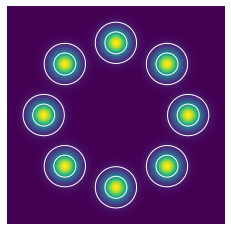

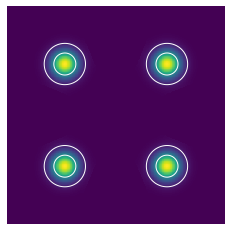

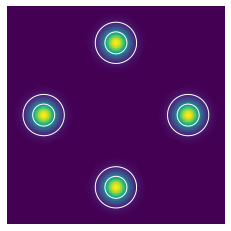

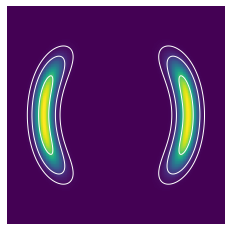

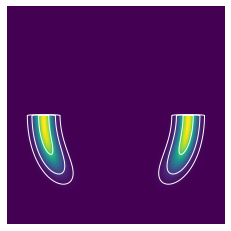

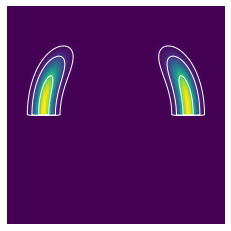

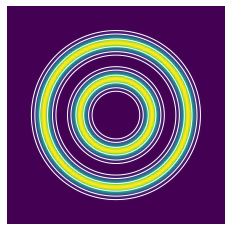

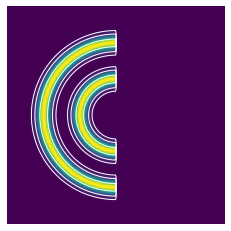

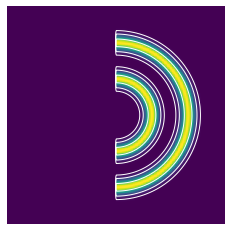

In [9]:
grid_size = 300
xx, yy = torch.meshgrid(torch.linspace(-3, 3, grid_size), torch.linspace(-3, 3, grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)

for dist in np.unique([dist for dist, *_ in models]).tolist():

    log_prob = get_dist(dist).log_prob(zz).cpu().view(*xx.shape)
    prob = torch.exp(log_prob)
    prob[torch.isnan(prob)] = 0
    prob_target = prob.data.numpy()

    fig = plt.plot(figsize=figsize)

    plt.pcolormesh(xx, yy, prob_target)
    cs = plt.contour(xx, yy, prob_target, [.025, .15, .7], colors='w', linewidths=1)
    plt.gca().set_aspect('equal', 'box')
    plt.axis('off')

    plt.savefig(f'{base_dir}/{dist}_gt_density.png', bbox_inches='tight')
    
    plt.show()
    
    for cls in [0, 1]:
        y = y_func_map[dist](zz)

        #log_prob = model.p.log_prob(zz).to('cpu').view(*xx.shape)
        prob = torch.exp(log_prob)
        prob[torch.isnan(prob)] = 0
        prob[(y == 1 - cls).view(*xx.shape)] = 0
        prob_target = prob.data.numpy()

        fig = plt.plot(figsize=figsize)

        plt.pcolormesh(xx, yy, prob_target)
        cs = plt.contour(xx, yy, prob_target, [.025, .15, .7], colors='w', linewidths=1)
        plt.gca().set_aspect('equal', 'box')
        plt.axis('off')

        plt.savefig(f'{base_dir}/{dist}_gt_density_{cls}.png', bbox_inches='tight')
        
        plt.show()

### Learned Densities

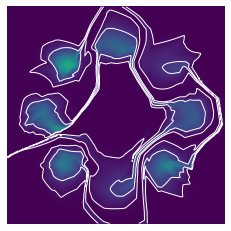

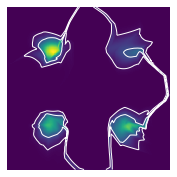

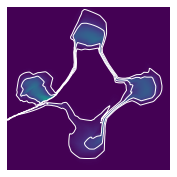

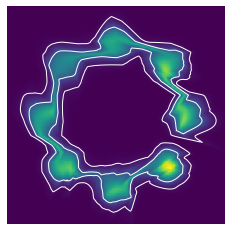

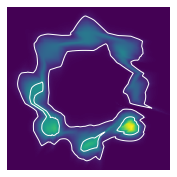

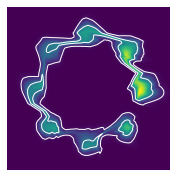

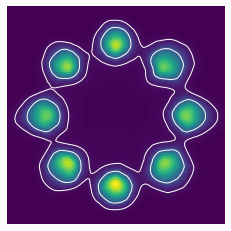

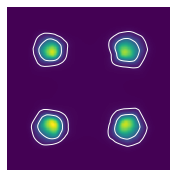

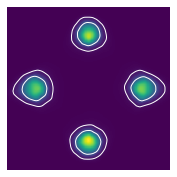

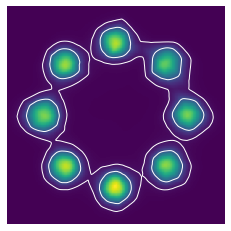

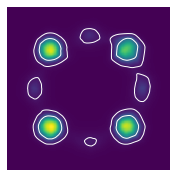

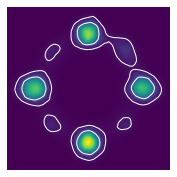

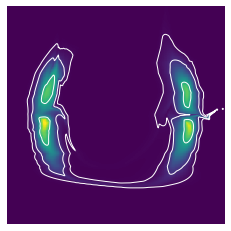

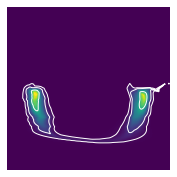

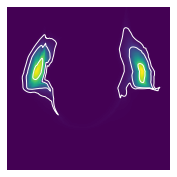

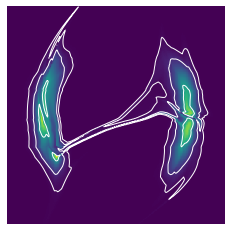

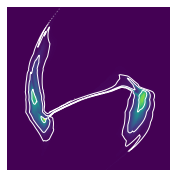

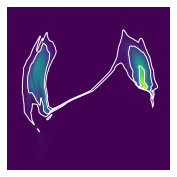

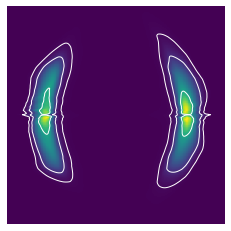

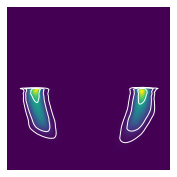

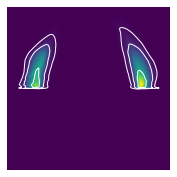

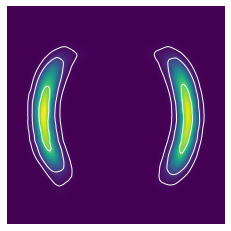

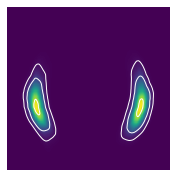

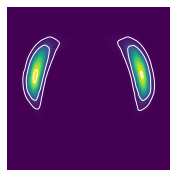

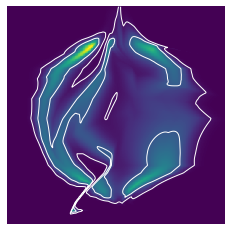

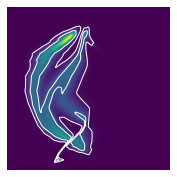

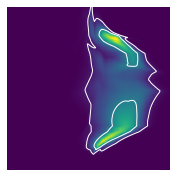

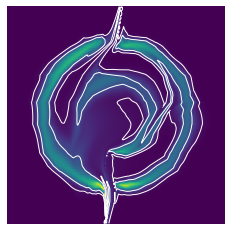

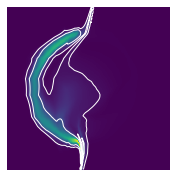

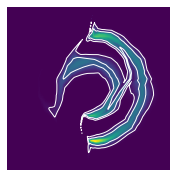

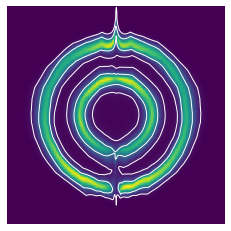

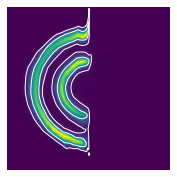

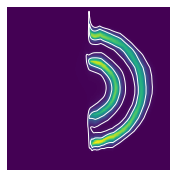

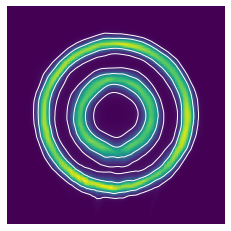

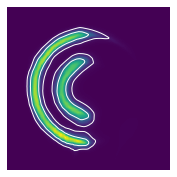

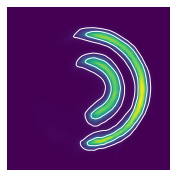

In [10]:
for dist, base, IB, model in models:
    fig = plt.plot(figsize=figsize)
    
    with torch.no_grad():
        log_prob = model.cuda().log_prob(zz.cuda()).to('cpu').view(*xx.shape)
        prob_margin, prob = model.cuda().log_prob(zz.cuda(), return_uncond_logp=True)
        prob_margin = torch.exp(prob_margin).to('cpu').view(*xx.shape)
        prob = torch.exp(prob).to('cpu').view(*xx.shape, model.q0.n_cls)
        prob_margin[torch.isnan(prob_margin)], prob[torch.isnan(prob)] = 0, 0

    plt.pcolormesh(xx, yy, prob_margin)
    cs = plt.contour(xx, yy, prob_margin, [.025, .15, .7], colors='w', linewidths=1)
    
    plt.gca().set_aspect('equal', 'box')
    plt.axis('off')

    plt.savefig(f'{base_dir}/{dist}_{base}_{"wib" if IB else "woib"}_density.png', bbox_inches='tight')
    
    plt.show()
    
    for idx, dim in enumerate(range(prob.shape[-1])):
        plt.figure(figsize=figsize)
        prob_ = prob[..., dim].view(*xx.shape).data.numpy()
        plt.pcolormesh(xx, yy, prob_)
        cs = plt.contour(xx, yy, prob_, [.025, .15, .7], colors='w', linewidths=1)
        
        plt.gca().set_aspect('equal', 'box')
        plt.axis('off')
         
        plt.savefig(f'{base_dir}/{dist}_{base}_{"wib" if IB else "woib"}_density_{idx}.png', bbox_inches='tight')
        
        plt.show()

### Base Distributions

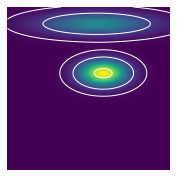

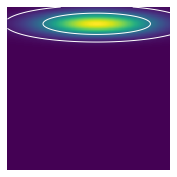

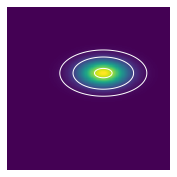

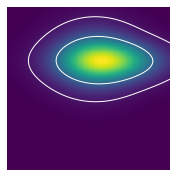

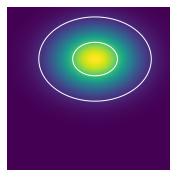

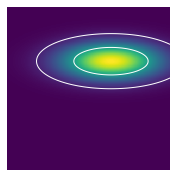

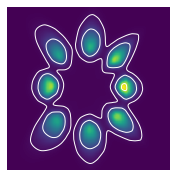

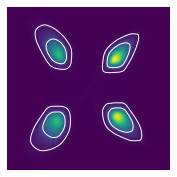

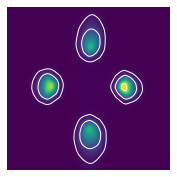

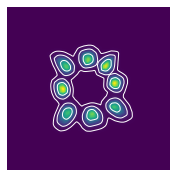

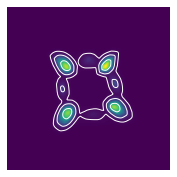

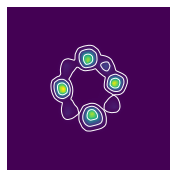

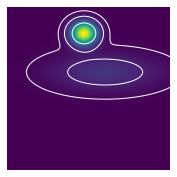

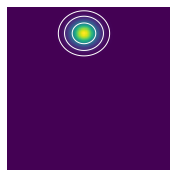

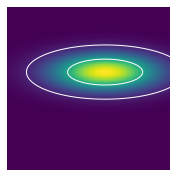

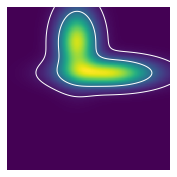

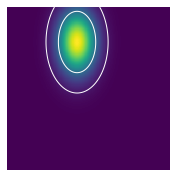

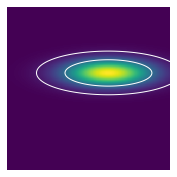

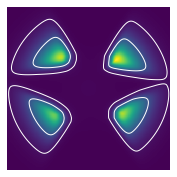

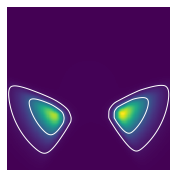

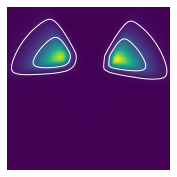

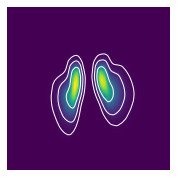

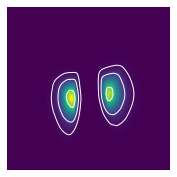

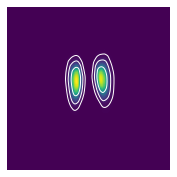

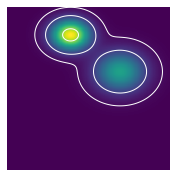

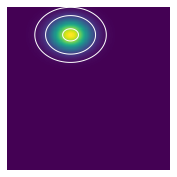

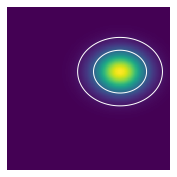

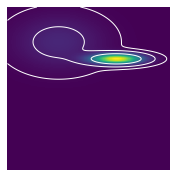

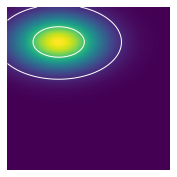

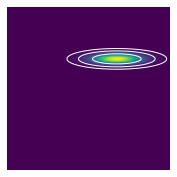

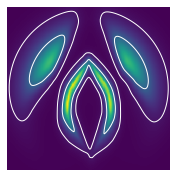

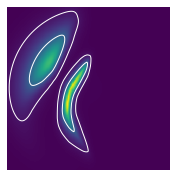

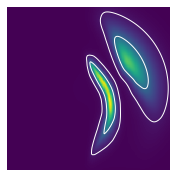

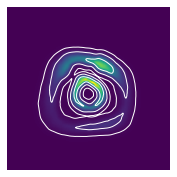

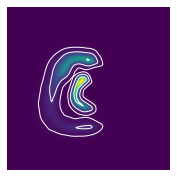

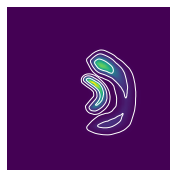

In [11]:
for dist, base, IB, model in models:
    prob_margin, prob = model.cuda().q0.log_prob(zz.cuda(), return_uncond_logp=True)
    prob_margin, prob = torch.exp(prob_margin).to('cpu'), torch.exp(prob).to('cpu')
    prob_margin[torch.isnan(prob_margin)], prob[torch.isnan(prob)] = 0, 0
    
    plt.figure(figsize=figsize)
    prob_ = prob_margin.view(*xx.shape).data.numpy()
    plt.pcolormesh(xx, yy, prob_)
    cs = plt.contour(xx, yy, prob_, [.025, .15, .7], colors='w', linewidths=1)

    plt.gca().set_aspect('equal', 'box')
    plt.axis('off')

    plt.savefig(f'{base_dir}/{dist}_{base}_{"wib" if IB else "woib"}_base.png', bbox_inches='tight')

    plt.show()

    for idx, dim in enumerate(range(prob.shape[-1])):
        plt.figure(figsize=figsize)
        prob_ = prob[..., dim].view(*xx.shape).data.numpy()
        plt.pcolormesh(xx, yy, prob_)
        cs = plt.contour(xx, yy, prob_, [.025, .15, .7], colors='w', linewidths=1)
        
        plt.gca().set_aspect('equal', 'box')
        plt.axis('off')
         
        plt.savefig(f'{base_dir}/{dist}_{base}_{"wib" if IB else "woib"}_base_{idx}.png', bbox_inches='tight')
        
        plt.show()

### Acceptance Functions  of cRSB

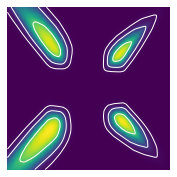

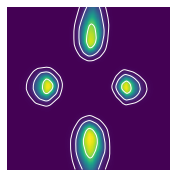

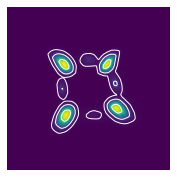

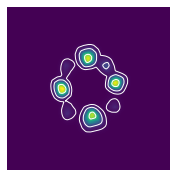

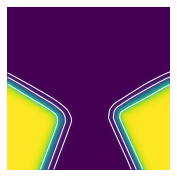

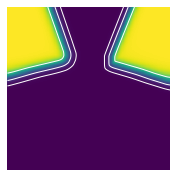

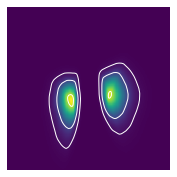

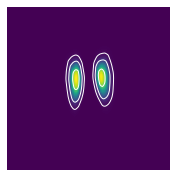

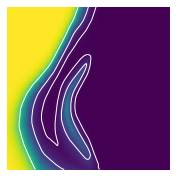

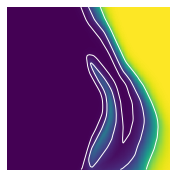

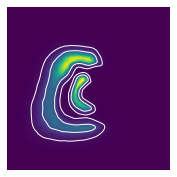

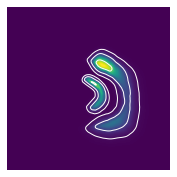

In [15]:
for dist, base, IB, model in models:
    if 'crsb' not in base:
        continue
    
    prob = model.q0.a(zz.cuda()).to('cpu')
    prob[torch.isnan(prob)] = 0

    for idx, dim in enumerate(range(prob.shape[-1])):
        plt.figure(figsize=figsize)
        prob_ = prob[..., dim].view(*xx.shape).data.numpy()
        plt.pcolormesh(xx, yy, prob_)
        cs = plt.contour(xx, yy, prob_, [.025, .15, .7], colors='w', linewidths=1)
        
        plt.gca().set_aspect('equal', 'box')
        plt.axis('off')
         
        plt.savefig(f'{base_dir}/{dist}_{base}_{"wib" if IB else "woib"}_a_{idx}.png', bbox_inches='tight')
        
        plt.show()

### Predictive Performance

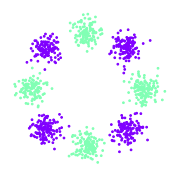

circle mog False 1.7252881526947021 1.751240849494934


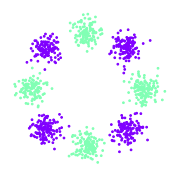

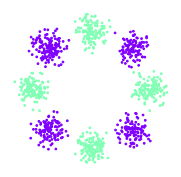

circle mog True 1.6075940132141113 2.335096836090088


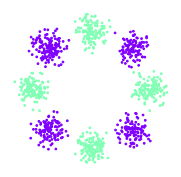

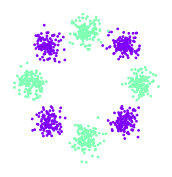

circle crsb False 1.495076060295105 1.5104730129241943


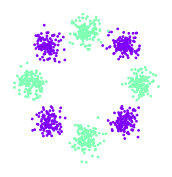

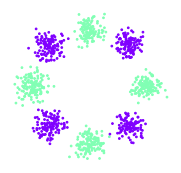

circle crsb True 1.491742491722107 1.605796456336975


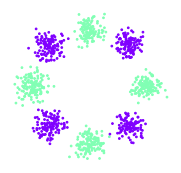

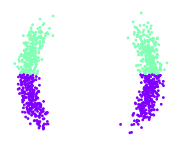

moons mog False 0.940883994102478 0.9566414952278137


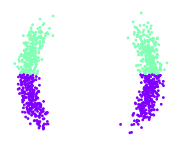

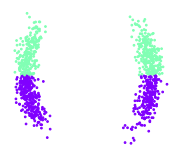

moons mog True 0.9278849363327026 1.1577918529510498


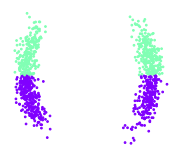

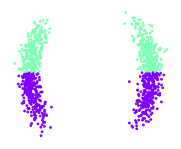

moons crsb False 0.8902062773704529 0.8969842195510864


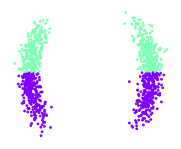

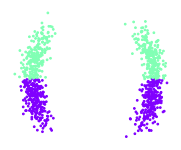

moons crsb True 0.899329662322998 1.0529828071594238


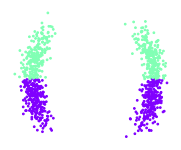

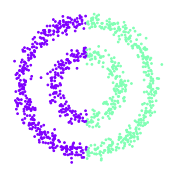

rings mog False 2.0263328552246094 2.052961826324463


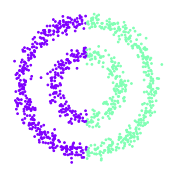

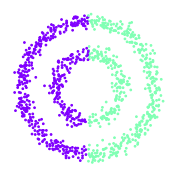

rings mog True 1.8054543733596802 2.000150442123413


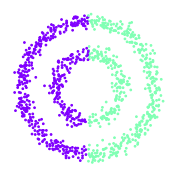

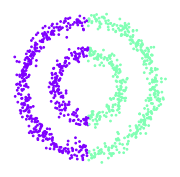

rings crsb False 1.6209114789962769 1.6344454288482666


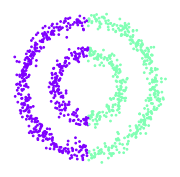

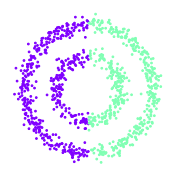

rings crsb True 1.6156187057495117 1.6695046424865723


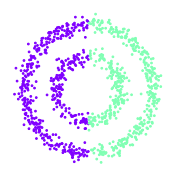

In [16]:
for dist, base, IB, model in models:
    x = model.p.sample(1024).cuda()
    y = y_func_map[dist](x)
    
    # Plot GT
    plt.figure(figsize=figsize)

    color_list = []
    for idx in range(x.shape[0]):
        # print(data)
        color_list.append(colors[-1 if y[idx].isnan() else int(y.cpu()[idx])])

    plt.scatter(x.cpu()[:, 0], x.cpu()[:, 1], c=color_list, s=3)

    plt.gca().set_aspect('equal', 'box')
    plt.axis('off')

    plt.savefig(f'{base_dir}/{dist}_gt_samples_cls.pdf', bbox_inches='tight')

    plt.show()
    
    
    # Plot Predictions
    plt.figure(figsize=figsize)
    
    y_pred = model.cuda().log_prob(x.cuda(), return_uncond_logp=True)[1].argmax(-1).cpu()
    
    color_list = []
    for idx in range(x.shape[0]):
        # print(data)
        color_list.append(colors[-1 if y[idx].isnan() else int(y.cpu()[idx])])

    plt.scatter(x.cpu()[:, 0], x.cpu()[:, 1], c=color_list, s=3)

    plt.gca().set_aspect('equal', 'box')
    plt.axis('off')

    plt.savefig(f'{base_dir}/{dist}_{base}_{"wib" if IB else "woib"}_samples_cls.pdf', bbox_inches='tight')
    
    y_oh = nn.functional.one_hot(y.to(torch.int64), model.q0.n_cls)
    print(dist, base, IB, model.cuda().forward_kld(x).item(), model.cuda().forward_kld(x, y_oh).item())

### KL divergence

In [17]:
for dist, base, IB, model in models:
    x = model.p.sample(1024).cuda()
    y = y_func_map[dist](x)
    
    y_oh = nn.functional.one_hot(y.to(torch.int64), model.q0.n_cls)
    print(dist, base, IB, model.cuda().forward_kld(x, y_oh).item())

circle mog False 1.8886643648147583
circle mog True 2.3345460891723633
circle crsb False 1.5780718326568604
circle crsb True 1.634199619293213
moons mog False 0.9794670343399048
moons mog True 1.2498669624328613
moons crsb False 0.9564260244369507
moons crsb True 1.0760265588760376
rings mog False 2.044674873352051
rings mog True 2.068189859390259
rings crsb False 1.6700339317321777
rings crsb True 1.692636251449585
